# SPLADE: Sparse Lexical and Expansion Model for First Stage Ranking

This notebook gives a minimal example usage of our SPLADE model. In a nutshell, SPLADE learns **sparse**, **expansion-based** query/doc representations for efficient first-stage retrieval.

Sparsity is induced via a regularization applied on representations, whose strength can be adjusted; it is thus possible to control the trade-off between effectiveness and efficiency. For more details, check our papers, and don't hesitate to reach out ! 
* v1 (SIGIR21 short paper): **SPLADE: Sparse Lexical and Expansion Model for First Stage Ranking**, https://arxiv.org/abs/2107.05720
* v2 (arxiv) new pooling + distillation: **SPLADE v2: Sparse Lexical and Expansion Model for Information Retrieval**, https://arxiv.org/abs/2109.10086

We provide weights for 4 models (in the `weights` folder):

| model | MRR@10 (MS MARCO dev) | recall@1000 (MS MARCO dev) | expected FLOPS | ~ avg q length | ~ avg d length | 
| --- | --- | --- | --- | --- | --- |
| `flops_best` (**v1**) | 32.2 | 95.5 | 0.73 | 15 | 58 |
| `flops_efficient` (**v1**) | 29.6 | 93.3 | 0.05 | 6 | 18 |
| `splade_max` (**v2**) | 34.0 | 96.5 | 1.32 | 18 | 92 |
| `distilsplade_max` (**v2**) | 36.8 | 97.9 | 3.82 | 25 | 232 |

In [ ]:
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

In [ ]:
class Splade(torch.nn.Module):

    def __init__(self, model_type_or_dir, agg="max"):
        super().__init__()
        self.transformer = AutoModelForMaskedLM.from_pretrained(model_type_or_dir)
        assert agg in ("sum", "max")
        self.agg = agg
    
    def forward(self, **kwargs):
        out = self.transformer(**kwargs)["logits"] # output (logits) of MLM head, shape (bs, pad_len, voc_size)
        if self.agg == "max":
            values, _ = torch.max(torch.log(1 + torch.relu(out)) * kwargs["attention_mask"].unsqueeze(-1), dim=1)
            return values
            # 0 masking also works with max because all activations are positive
        else:
            return torch.sum(torch.log(1 + torch.relu(out)) * kwargs["attention_mask"].unsqueeze(-1), dim=1)

In [ ]:
# set the dir for trained weights 
# NOTE: because between v1 and v2 we switched the pooling mechanism (better results with max), we need to prodive
# the agg argument depending on the set of weights we want to use

#### v1
# agg = "sum"
# model_type_or_dir = "weights/flops_efficient"
# model_type_or_dir = "weights/flops_best"

##### v2
agg = "max"
model_type_or_dir = "output/0_MLMTransformer"
# model_type_or_dir = "weights/distilsplade_max"

In [ ]:
# loading model and tokenizer

model = Splade(model_type_or_dir, agg=agg)
model.eval()
model.to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_type_or_dir)
reverse_voc = {v: k for k, v in tokenizer.vocab.items()}

In [ ]:
# example document from MS MARCO passage collection (doc_id = 8003157)

doc = "Glass and Thermal Stress. Thermal Stress is created when one area of a glass pane gets hotter than an adjacent area."

In [ ]:
# now compute the document representation
from tqdm import tqdm
import gzip 
import json

scale = 100
file_per = 100000
i = 0
fo = None
with open("../msmarco/collection.tsv") as f:
    for line in tqdm(f):
        if i % file_per == 0:
            if fo is not None:
                fo.close()
            fo = gzip.open(f"splade_index/file_{i // file_per}.jsonl.gz", "w")
            
        did, doc = line.strip().split("\t")     
        with torch.no_grad():
            doc_rep = model(**tokenizer(doc, return_tensors="pt").to('cuda')).squeeze()  # (sparse) doc rep in voc space, shape (30522,)

        # get the number of non-zero dimensions in the rep:
        col = torch.nonzero(doc_rep).squeeze().cpu().tolist()
        #print("number of actual dimensions: ", len(col))

        # now let's inspect the bow representation:
        weights = doc_rep[col].cpu().tolist()
        d = {reverse_voc[k]: int(v * scale) for k, v in zip(col, weights)}
        outline = json.dumps({"id": int(did), "content": doc, "vector": d}) + "\n"
        fo.write(outline.encode('utf-8'))
        fo.flush()
        i += 1

In [ ]:
# now compute the document representation
with torch.no_grad():
    doc_rep = model(**tokenizer(doc, return_tensors="pt", truncation=True).to('cuda')).squeeze()  # (sparse) doc rep in voc space, shape (30522,)

# get the number of non-zero dimensions in the rep:
col = torch.nonzero(doc_rep).squeeze().cpu().tolist()
#print("number of actual dimensions: ", len(col))

# now let's inspect the bow representation:
weights = doc_rep[col].cpu().tolist()
d = {k: v for k, v in zip(col, weights)}
sorted_d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
bow_rep = []
for k, v in sorted_d.items():
    bow_rep.append((reverse_voc[k], round(v, 2)))
print("SPLADE BOW rep:\n", bow_rep)

In [ ]:
doc_rep.shape

In [ ]:
# now compute the document representation
from tqdm import tqdm
import gzip 
import json

scale = 1
file_per = 100000
i = 0
fo = None
with open("../msmarco/queries.dev.tsv") as f:
    for line in tqdm(f):
        did, doc = line.strip().split("\t")     
        with torch.no_grad():
            doc_rep = model(**tokenizer(doc, return_tensors="pt").to('cuda')).squeeze()  # (sparse) doc rep in voc space, shape (30522,)

        # get the number of non-zero dimensions in the rep:
        col = torch.nonzero(doc_rep).squeeze().cpu().tolist()
        weights = doc_rep[col].cpu().tolist()
        d = {reverse_voc[k]: v * scale for k, v in zip(col, weights)}
        outline = json.dumps({"id": int(did), "content": doc, "vector": d}) + "\n"
        print(outline, sum(d.values()))

In [ ]:
# top k inference
from collections import defaultdict
from tqdm import tqdm

qrels = defaultdict(dict)
with open("../msmarco/2020qrels-pass.txt") as f:
    for line in f:
        qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)

            
topk = open("../msmarco/msmarco-passagetest2020-top1000.tsv")

query_weights = dict()
run = defaultdict(dict)
for line in tqdm(topk):
    qid, did, qtext, dtext = line.strip().split("\t")
    if len(qrels[qid]) == 0:
        continue
    if int(qid) not in query_weights:
        q_rep = model(**tokenizer(qtext, return_tensors="pt").to('cuda')).squeeze() 
        col = torch.nonzero(q_rep).squeeze().cpu().tolist()
        weights = q_rep[col].cpu().tolist()
        query_weights[int(qid)] = {k: v for k, v in zip(col, weights)}
        del q_rep
    d_rep = model(**tokenizer(dtext, return_tensors="pt", truncation=True).to('cuda')).squeeze().cpu().tolist()
    score = 0
    for k in query_weights[int(qid)]:
        score += d_rep[k] * query_weights[int(qid)][k]

    run[qid][did] = score
    del d_rep

In [6]:
import pytrec_eval
from statistics import mean

            
VALIDATION_METRIC = 'ndcg_cut_10' 
trec_eval = pytrec_eval.RelevanceEvaluator(qrels, {VALIDATION_METRIC})
eval_scores = trec_eval.evaluate(run)
mean([d['ndcg_cut_10'] for d in eval_scores.values()])

0.7188020043767575

In [4]:
import json
run = json.loads(open("output_64x1_0.01_0.088_100k_fromsplade_reverse3_nocls_2020.run.json").readline())

In [5]:
# top k inference
from collections import defaultdict
from tqdm import tqdm

qrels = defaultdict(dict)
with open("../msmarco/2019qrels-pass.txt") as f:
    for line in f:
        qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)

In [10]:

from collections import defaultdict
import pytrec_eval
from statistics import mean
import sys


linein = open("../msmarco/wentai_splade_2020.trec")

collections = dict()
with open("../msmarco/collection.tsv") as f:
    for line in f:
        did, dtext = line.strip().split("\t")
        collections[did] = dtext

queries = dict()
with open("../msmarco/msmarco-passagetest2020-top1000.tsv") as f:
    for line in f:
        qid, _, qtext, _ = line.strip().split("\t")
        queries[qid] = qtext

lineout = open("../msmarco/wentai_splade_2020_top1000.tsv",'w')
for line in linein:
    try:
        qid,did,score = line.strip().split("\t")
    except:
        qid, _, did, _, score, _ = line.strip().split("\t")
    if qid in queries:
        lineout.write(f"{qid}\t{did}\t{queries[qid]}\t{collections[did]}\n")
        lineout.flush()


In [11]:
import os
import gzip 
import tqdm
hard_negatives_filepath = os.path.join("../msmarco", 'msmarco-hard-negatives.jsonl.gz')
i = 0
with gzip.open(hard_negatives_filepath, 'rt') as fIn:
    for line in tqdm.tqdm(fIn):
        i+=1


808731it [00:24, 33560.32it/s]


'2928707'

# Compare splade, colbert, colbert on splade negative tops

In [17]:
from collections import defaultdict
queries = dict()
docs = dict()

with open("../msmarco/wentai_splade_2019_top1000.tsv") as f:
    for line in f:
        qid, did, qtext, dtext = line[:-1].split("\t")
        queries[qid] = qtext
        docs[did] = dtext
        
bmtops = defaultdict(dict)
with open("../msmarco/msmarco-passagetest2019-top1000.tsv") as f:
    for line in f:
        qid, did, qtext, dtext = line[:-1].split("\t")
        bmtops[qid][did] = 1

In [5]:

run_splade = defaultdict(dict)
with open('../msmarco/wentai_splade_2019.trec') as f:
    for line in f:
        qid, _, did, rank, score, _ = line[:-1].split("\t")
        run_splade[qid][did] = float(score)

run_colbert = defaultdict(dict)
with open("results/output_19-on-splade_colbert_271k.run.json.tsv") as f:
    for line in f:
        qid, did, score = line[:-1].split("\t")
        run_colbert[qid][did] = float(score)

run_colspla = defaultdict(dict)
with open("results/output_19-on-splade_colspla_from_colbert_3e-6_negpersys5_200k.run.json.tsv") as f:
    for line in f:
        qid, did, score = line[:-1].split("\t")
        run_colspla[qid][did] = float(score)

qrels = defaultdict(dict)
with open("../msmarco/2019qrels-pass.txt") as f:
    for line in f:
        qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)

In [6]:
import pytrec_eval
from statistics import mean
eval_scores_all = dict()
            
VALIDATION_METRIC = 'ndcg_cut_10' 
trec_eval = pytrec_eval.RelevanceEvaluator(qrels, {VALIDATION_METRIC})
eval_scores1 = trec_eval.evaluate(run_splade)
print("splade", mean([d['ndcg_cut_10'] for d in eval_scores1.values()]))
for k in eval_scores1:
    eval_scores_all[k] = {"splade": eval_scores1[k][VALIDATION_METRIC]}
eval_scores2 = trec_eval.evaluate(run_colbert)
print("colbert", mean([d['ndcg_cut_10'] for d in eval_scores2.values()]))
for k in eval_scores2:
    eval_scores_all[k]["colbert"] = eval_scores2[k][VALIDATION_METRIC]
eval_scores3 = trec_eval.evaluate(run_colspla)
print("colspla", mean([d['ndcg_cut_10'] for d in eval_scores3.values()]))
for k in eval_scores3:
    eval_scores_all[k]["colspla"] = eval_scores3[k][VALIDATION_METRIC]
eval_scores_all

splade 0.7303911126944296
colbert 0.7485866483306821
colspla 0.7287220150335789


{'156493': {'splade': 0.9295204907858211,
  'colbert': 0.9361767385157805,
  'colspla': 0.9634117275431489},
 '1110199': {'splade': 0.8634146680520659,
  'colbert': 0.868468279273479,
  'colspla': 0.9307311821393774},
 '1063750': {'splade': 0.8381657123202058,
  'colbert': 0.8484359194787117,
  'colspla': 0.810044521833171},
 '130510': {'splade': 0.9214968075846053,
  'colbert': 0.891997905670028,
  'colspla': 0.8661977124852224},
 '489204': {'splade': 0.25954554301360316,
  'colbert': 0.5151644069303914,
  'colspla': 0.2852222999245085},
 '573724': {'splade': 0.6055841535389161,
  'colbert': 0.5400784922418287,
  'colspla': 0.547447181115217},
 '168216': {'splade': 1.0, 'colbert': 0.9787930706003494, 'colspla': 1.0},
 '1133167': {'splade': 0.6887514078181296,
  'colbert': 0.8272936451932225,
  'colspla': 0.7266438273370572},
 '527433': {'splade': 0.593884615060238,
  'colbert': 0.5654237443364081,
  'colspla': 0.5849387404207256},
 '1037798': {'splade': 0.21178415686477028,
  'colbert

In [7]:
qid = '489204'

In [8]:
eval_scores_all[qid]

{'splade': 0.25954554301360316,
 'colbert': 0.5151644069303914,
 'colspla': 0.2852222999245085}

In [9]:
qrels[qid]

{'1051494': 1,
 '1051498': 2,
 '1090435': 1,
 '1114410': 1,
 '1231674': 1,
 '1231678': 2,
 '1383251': 1,
 '1430550': 2,
 '1431271': 1,
 '1479542': 2,
 '1513820': 1,
 '152948': 1,
 '1557550': 2,
 '1664640': 2,
 '1664643': 1,
 '1778458': 1,
 '1820199': 1,
 '1820203': 2,
 '187571': 1,
 '1905740': 1,
 '216492': 1,
 '2445205': 2,
 '2645311': 1,
 '2899721': 1,
 '3049941': 1,
 '320071': 1,
 '320073': 2,
 '320076': 1,
 '320079': 2,
 '3310420': 1,
 '3353678': 1,
 '3353685': 1,
 '3438217': 1,
 '34400': 1,
 '3710413': 1,
 '3980122': 1,
 '415420': 1,
 '4159098': 2,
 '4159416': 2,
 '4222521': 1,
 '4538296': 1,
 '4574496': 1,
 '4586570': 2,
 '4662177': 1,
 '5005765': 1,
 '5143975': 1,
 '5156386': 1,
 '518994': 1,
 '5513331': 1,
 '5541646': 1,
 '5640841': 1,
 '5640844': 2,
 '5640846': 1,
 '5640849': 1,
 '5815957': 1,
 '5842850': 1,
 '5856565': 1,
 '5856566': 1,
 '5856571': 1,
 '5895917': 1,
 '6087666': 1,
 '6327175': 1,
 '6435264': 1,
 '6581779': 1,
 '6620077': 1,
 '6727272': 2,
 '6816322': 2,
 '6879

In [10]:
queries[qid]

'right pelvic pain causes'

In [11]:
def sort_results(doc_dict, qid):
    doclist = sorted(doc_dict.items(), key = lambda x: -x[1])
    results = []
    for item in doclist:
        if item[0] in qrels[qid]:
            results.append([item[0], item[1], qrels[qid][item[0]]])
        else:
            results.append([item[0], item[1], 0])
    return results
sort_results(run_splade[qid], qid)

[['1778458', 111606.0, 1],
 ['4586570', 107045.0, 2],
 ['2268657', 105852.0, 0],
 ['3728445', 105525.0, 0],
 ['152954', 105409.0, 0],
 ['8594272', 104539.0, 1],
 ['3608627', 104202.0, 0],
 ['6652052', 104009.0, 0],
 ['1759354', 103984.0, 0],
 ['6327174', 103607.0, 0],
 ['8594271', 103601.0, 0],
 ['5895917', 103355.0, 1],
 ['6087666', 103246.0, 1],
 ['1051498', 103068.0, 2],
 ['8737051', 103040.0, 1],
 ['6327175', 102883.0, 1],
 ['855972', 102618.0, 0],
 ['1538587', 102387.0, 0],
 ['1479542', 102295.0, 2],
 ['4917998', 102034.0, 0],
 ['1225589', 101736.0, 0],
 ['4552409', 101551.0, 0],
 ['7432758', 101525.0, 0],
 ['1225591', 101201.0, 0],
 ['152948', 101072.0, 1],
 ['6542578', 100975.0, 0],
 ['1231677', 100841.0, 0],
 ['2268651', 100724.0, 0],
 ['385083', 100637.0, 0],
 ['8594280', 100443.0, 0],
 ['7116533', 100077.0, 0],
 ['3053140', 100019.0, 0],
 ['5856571', 99950.0, 1],
 ['855963', 99934.0, 1],
 ['8054792', 99892.0, 0],
 ['5629373', 99883.0, 0],
 ['8594273', 99817.0, 0],
 ['6327177'

In [12]:
sort_results(run_colbert[qid], qid)

[['1778458', 27.836061477661133, 1],
 ['8737051', 26.57796287536621, 1],
 ['1051498', 26.541061401367188, 2],
 ['8594272', 26.482135772705078, 1],
 ['1479542', 26.40517807006836, 2],
 ['4586570', 26.150785446166992, 2],
 ['5856571', 26.138782501220703, 1],
 ['5895917', 26.092426300048828, 1],
 ['3608627', 26.02104949951172, 0],
 ['152954', 25.900772094726562, 0],
 ['1759354', 25.870601654052734, 0],
 ['533017', 25.869606018066406, 0],
 ['1538587', 25.858020782470703, 0],
 ['1225589', 25.842512130737305, 0],
 ['3728445', 25.83050537109375, 0],
 ['1225591', 25.784053802490234, 0],
 ['855972', 25.766660690307617, 0],
 ['5541647', 25.72799301147461, 0],
 ['385083', 25.68177604675293, 0],
 ['1231677', 25.64566421508789, 0],
 ['8585817', 25.641918182373047, 0],
 ['4159416', 25.634201049804688, 2],
 ['4917998', 25.5627498626709, 0],
 ['6652052', 25.54471778869629, 0],
 ['8585822', 25.526744842529297, 0],
 ['3898929', 25.488765716552734, 0],
 ['6327174', 25.480371475219727, 0],
 ['533011', 25.

In [13]:
sort_results(run_colspla[qid], qid)

[['1778458', 22.746196746826172, 1],
 ['5856571', 21.612762451171875, 1],
 ['8594272', 21.377084732055664, 1],
 ['8737051', 21.27147674560547, 1],
 ['5541647', 21.2353515625, 0],
 ['533017', 21.218976974487305, 0],
 ['3608627', 21.120317459106445, 0],
 ['5895917', 21.105924606323242, 1],
 ['1225591', 20.98806381225586, 0],
 ['1538587', 20.958864212036133, 0],
 ['8585817', 20.943431854248047, 0],
 ['1231677', 20.873241424560547, 0],
 ['1225589', 20.817848205566406, 0],
 ['533011', 20.781702041625977, 0],
 ['6327174', 20.764423370361328, 0],
 ['1759354', 20.716463088989258, 0],
 ['4917998', 20.709943771362305, 0],
 ['4586570', 20.701370239257812, 2],
 ['6652052', 20.674312591552734, 0],
 ['6327175', 20.64760971069336, 1],
 ['4159416', 20.644697189331055, 2],
 ['6973244', 20.603696823120117, 0],
 ['385083', 20.500667572021484, 0],
 ['2915963', 20.482227325439453, 0],
 ['216492', 20.462629318237305, 1],
 ['855972', 20.43283462524414, 0],
 ['1167659', 20.431228637695312, 0],
 ['1360631', 20

In [19]:
docs['5541647']

'Most commonly, the pain is not a result of anything dangerous and may occur with excessive gas or constipation. Less common but more serious causes of right lower abdominal pain include appendicitis, which may be associated with nausea, vomiting, fever and loss of appetite. A bowel obstruction can also cause pain in this area and occurs when your intestines become blocked. Other less common causes of right lower abdominal pain include colon cancer as well as Crohn disease and ulcerative colitis, inflammatory diseases that may cause recurrent abdominal pain.'

In [22]:
import scipy.stats as stats

In [26]:
#colbert, colspla
stats.kendalltau([x[0] for x in sort_results(run_colbert[qid], qid)[:10]], [x[0] for x in sort_results(run_colspla[qid], qid)[:10]])

KendalltauResult(correlation=0.06666666666666667, pvalue=0.8618005952380953)

In [27]:
#colbert, splade
stats.kendalltau([x[0] for x in sort_results(run_colbert[qid], qid)[:10]], [x[0] for x in sort_results(run_splade[qid], qid)[:10]])

KendalltauResult(correlation=-0.06666666666666667, pvalue=0.8618005952380953)

In [28]:
#colspla, splade
stats.kendalltau([x[0] for x in sort_results(run_colspla[qid], qid)[:10]], [x[0] for x in sort_results(run_splade[qid], qid)[:10]])

KendalltauResult(correlation=-0.1111111111111111, pvalue=0.7274895282186948)

In [29]:
kt_splade_colbert = []
kt_splade_colspla = []
kt_colbert_colspla = []
for qid in run_splade.keys():
    
    kt_splade_colbert.append(stats.kendalltau([x[0] for x in sort_results(run_colbert[qid], qid)[:10]], [x[0] for x in sort_results(run_splade[qid], qid)[:10]])[0])
    kt_splade_colspla.append(stats.kendalltau([x[0] for x in sort_results(run_colspla[qid], qid)[:10]], [x[0] for x in sort_results(run_splade[qid], qid)[:10]])[0])
    kt_colbert_colspla.append(stats.kendalltau([x[0] for x in sort_results(run_colspla[qid], qid)[:10]], [x[0] for x in sort_results(run_colbert[qid], qid)[:10]])[0])
    

In [30]:
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

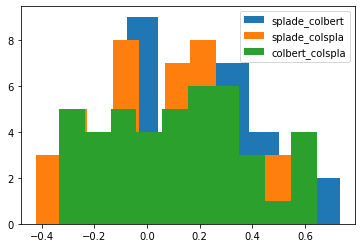

In [31]:
fig, ax = plt.subplots()

ax.hist(kt_splade_colbert, label = "splade_colbert")

ax.hist(kt_splade_colspla, label="splade_colspla")
ax.hist(kt_colbert_colspla, label="colbert_colspla")


ax.legend()

plt.show() 

In [72]:
import pandas as pd
pd.Series(kt_splade_colbert).describe()

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.7 MB 22.6 MB/s eta 0:00:01


count    43.000000
mean      0.172610
std       0.305383
min      -0.466667
25%      -0.022222
50%       0.155556
75%       0.355556
max       0.822222
dtype: float64

In [73]:
pd.Series(kt_splade_colspla).describe()

count    43.000000
mean      0.119897
std       0.241353
min      -0.422222
25%       0.022222
50%       0.155556
75%       0.288889
max       0.511111
dtype: float64